# Introduction to Machine Learning and Deep Learning

### Acknowledgements

The content of this notebook was originally created by Nils Eckstein, Julia Buhmann, and Jan Funke for the 2021 DL@MBL course in Woods Hole, and later chopped up and modified by Florian Jug, Igor Zubarev and Ashesh for the 2023 course DL4MIA.

Some code cells will be marked with

########################################################################### <br>
#######                      START OF YOUR CODE                     ####### <br>
########################################################################### <br>

... <br>

########################################################################### <br>
#######                       END OF YOUR CODE                      ####### <br>
########################################################################### <br>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

/Users/ashesh.ashesh/miniconda3/envs/Disentangle/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Use PyTorch to Train a (Small) Neural Network

The previous task demonstrated that chosing the weights of a neural network by hand can be quite painful even for simple functions. This will certainly get out of hand once we have more complex networks with several layers and many neurons per layer. But more importantly, the reason why we want to use neural networks to approximate a function is that (in general) we do not know exactly what the function is. We only have data points that describe the function implicitly.

In this task, we will design, train, and evaluate a neural network that can classify points of two different classes on a 2D plane, i.e., the input to our network are the coordinates of points in a plane. Net initial network we want to build should have one hidden layer containing 12 nodes (perceptrons) that receive input from two nodes each, and are themselves connected to one single output node that should predict a binary class for the given input (x,y).

For training this network, we will create a training and a testing dataset. We will then create the network and use stochastic gradient descent to train all network parameters on the training dataset and evaluate its performance on the testing dataset.

## Generate Training Data...

We create both training and testing dataset from the following function (in practice, we would not know this function but have only the data available):

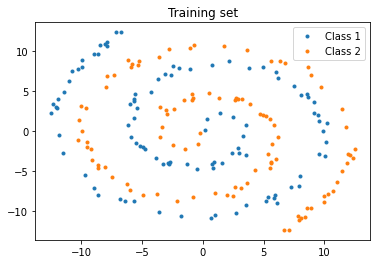

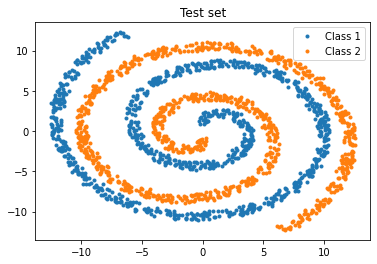

In [3]:
def generate_spiral_data(n_points, noise=1.0):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X_train, y_train = generate_spiral_data(100)

plt.title('Training set')
plt.plot(X_train[y_train==0,0], X_train[y_train==0,1], '.', label='Class 1')
plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], '.', label='Class 2')
plt.legend()
plt.show()

X_test, y_test = generate_spiral_data(1000)

plt.title('Test set')
plt.plot(X_test[y_test==0,0], X_test[y_test==0,1], '.', label='Class 1')
plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], '.', label='Class 2')
plt.legend()
plt.show()

### Helper functions


In [4]:
import torch

def accuracy(binary_prediction, target):
    """Computes the accuracy of a binary prediction vector and a target vector"""
    assert binary_prediction.shape == target.shape, f"Shapes don't match: {binary_prediction.shape} vs {target.shape}"
    assert isinstance(binary_prediction, torch.Tensor), f"Expected torch.Tensor, got {type(binary_prediction)}"
    assert isinstance(target, torch.Tensor), f"Expected torch.Tensor, got {type(target)}"
    x = binary_prediction == target
    return x.sum().div(len(x))


def get_binary_predictions(model_predictions):
   """Converts a vector of probabilities to a vector of binary predictions"""
   return torch.round(model_predictions)


# Let's create and train the network on the generated data...

Try to understand what is roughly going on in the cell below... feel free to use google to figure out what some parts might mean...

In [5]:
y_train.shape

(200,)

In [7]:
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

# hyper parameters.
batch_size = 32
learning_rate = 0.01
momentum = 0.5

# data
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train[:,None])) # create your dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size) # create your dataloader


def train(model, optimizer, num_epochs):    
  train_losses = []
  train_accuracies = []
  for epoch in tqdm(range(num_epochs)):
    output = train_one_epoch(model, optimizer)
    train_losses.append(output['loss'])
    train_accuracies.append(output['accuracy'])
  return {'loss':train_losses, 'accuracy':train_accuracies}

     

def train_one_epoch(model, optimizer):
  model.train()
  loss_arr = []
  accuracy_arr = []
  for data, target in train_loader:
    optimizer.zero_grad()
    output = model(data)
    loss = nn.MSELoss()(output, target)
    loss.backward()
    optimizer.step()
    binary_preds = get_binary_predictions(output)
    accuracy_arr.append(accuracy(binary_preds, target))
    loss_arr.append(loss.item())

  return {'output':output, 'loss':np.mean(loss_arr), 'accuracy':np.mean(accuracy_arr)}




# Lets create the model 
simple_model  = nn.Sequential(
    nn.Linear(2, 12),
    nn.Tanh(),
    nn.Linear(12,1),
    nn.Sigmoid()
)
# visualize the model
print(simple_model)

# Lets create the optimizer
simple_optimizer = optim.SGD(simple_model.parameters(), lr=learning_rate,
                      momentum=momentum)
# Train the model
train_stats = train(simple_model, simple_optimizer, 100)

# Predict on the testing data
model_output = simple_model(torch.Tensor(X_test))
prediction = get_binary_predictions(model_output)

Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): Tanh()
  (2): Linear(in_features=12, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 100/100 [00:00<00:00, 534.70it/s]


Now that training is done, let's plot the results...

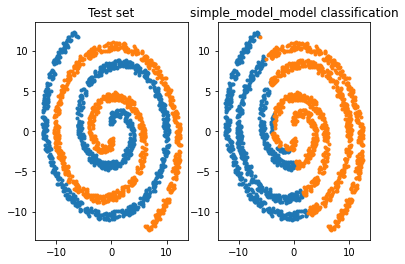

In [8]:
def plot_results(pred, model_name):
    plt.subplot(1,2,1)

    plt.title('Test set')
    plt.plot(X_test[y_test==0,0], X_test[y_test==0,1], '.')
    plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], '.')
    plt.subplot(1,2,2)

    plt.title(f'{model_name}_model classification')
    plt.plot(X_test[pred==0,0], X_test[pred==0,1], '.')
    plt.plot(X_test[pred==1,0], X_test[pred==1,1], '.')
    plt.show()

plot_results(prediction[:,0], 'simple_model')

And the result is... **BAD!**

This is, because the network is likely not powerful enough... hence, the model we used is not adequate for the training task at hand.

## Exercise: find a better solution...

Create a second network that is somehow different and performs the task better...

**Hint**: Likely it is a good idea to copy the cell from above and somehow change it in a meaningful way.

In [9]:
###########################################################################
#######                      START OF YOUR CODE                     #######
###########################################################################

# create an alternative model (network) here.
# Take the code of simple_model as a starting point and modify it.

good_model = ...

###########################################################################
#######                       END OF YOUR CODE                      #######
###########################################################################

# Visualize the architecture 
print(good_model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=128, out_features=1, bias=True)
  (7): Sigmoid()
)


# Train the model
Write the configuration and training code in the following cell.

**Hint**: You'd need to configure model for training with compile function, provide training data and hyperparameters

In [10]:
# Configure model for training
###########################################################################
#######                      START OF YOUR CODE                     #######
###########################################################################

# Hint: You can use the same optimizer as before, but you might want to change it to something else, like Adam ;) 
good_optimizer = ...


#Hint: And train the newly created model using train() function with correct optimizer and number of epochs
#Hint: Try to change the number of epochs to something else than 100 and see how it affects the results. Should it be bigger or smaller in this case?
train_stats = ...
###########################################################################
#######                       END OF YOUR CODE                      #######
###########################################################################

100%|██████████| 400/400 [00:01<00:00, 277.89it/s]


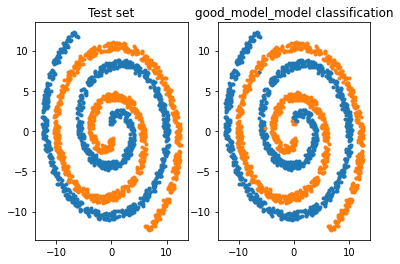

In [11]:
prediction = np.round((good_model(torch.Tensor(X_test))).detach().numpy())
plot_results(prediction[:,0], 'good_model')


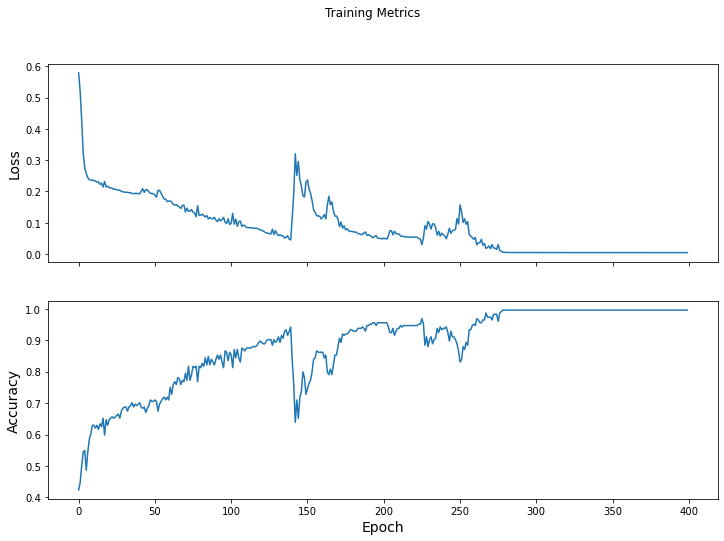

In [12]:
# Plot training metrics
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_stats['loss'])
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_stats['accuracy'])
plt.show()

### Done? Cooool!

You should now make a short coding break and visit the website https://playground.tensorflow.org

Play a bit with it... figure out what elements are part of a typical network training workflow.